# QCoDeS Example with QDevil_QDAC

In [ ]:
import qcodes as qc
import numpy as np
from time import sleep
import qcodes.instrument_drivers.QDevil.QDevil_QDAC as QDac
from qcodes.instrument_drivers.QDevil.QDevil_QDAC import Mode

## Initialisation
When initialised, the driver will read in the state of the QDAC to the extend spossible. This means that initialisation does not change any outputs, implying that any ongoing ramping is continuing undisturbed. The initialisation is, however, **not** able to figure out if any **slopes** have been assigned to channels, see later. So these will have to be set again by the user. 

During the initialisation all channels are queried in order to update the parmeter cache. However, as the current query is very slow due to the long current sensor integration time, it is optional to update currents. They are only read at startup if the **update_currents** flag is set to True.  

NOTE: After switching the QDAC off and back on the driver has to be re-initialised, OR the reset() command has to be executed.

In [ ]:
# Connect to the instrument
# By default the initialisation skips reading the current sensors on all channels
# as this takes some 0.2-0.5 secs per channel due to the sensor settling time. 
# You can force reading the current sensors at startup by specifiying "update_currents=True" in the call.

qdac = QDac.QDac(name='qdac', address='ASRL2::INSTR', update_currents=False)
print("Number of channels: ",qdac.num_chans)

## Basic QDAC Usage

The QDevil_QDAC driver supports controlling each individual BNC output channel. Each output channel "qdac.ch##." has seven attributes:
  * v: DC voltage
  * i: Current out (read-only)
  * mode: the combined voltage output and current sensor range: Mode.vhigh_ihigh, Mode.vhigh_ilow, Mode.vlow_ilow
  * slope: Maximum ramp rate for an output channel when changing teh DC voltage,v.
  * sync: Sync output assigned to a channel 
  * sync_delay: Sync pulse delay  
  * sync_duration: Sync pulse duration
  
The slope is the (maximal) slope in V/s that the channel will allow its voltage to change by. By default, all channels have a slope of "Inf". The slope can be changed dynamically, but no more than 8 channels can be ramped simultaneously.

In addition this driver supports:
   * Reset the QDAC to start up conditions. Allows continuing operation after the QDAC has been 
     powered off/on without restarting teh driver
   * Simultaneous ramping of up to 8 channels
   * 2D ramping of two groups of channels (slow and fast channels, up to 8 in total)
   * Override of protection against mode change for non-zero output voltages
   * Reading the internal temperature sensors 
   * Pretty printing the state of all channels, of assigned sync outputs and of assigned slopes 

### Setting voltages and reading currents

In [ ]:
# Setting the output voltage of a channel using "set"
qdac.ch01.v.set(1)
# Reading the output voltage of a channel using "get"
print('Channel 1 voltage: {} {}'.format(qdac.ch01.v.get(), qdac.ch01.v.unit))

In [ ]:
# Setting the output voltage of a channel using short-hand notation, which is used hereafter
qdac.ch01.v(-1)
# Reading the output voltage of a channel using short hand notion "qdac.ch01.v()", which is used hereafter
print('Channel 1 voltage: {} {}'.format(qdac.ch01.v(), qdac.ch01.v.unit))

In [ ]:
# Reading the current output of a channel  
print(qdac.ch01.i(), qdac.ch01.i.unit)

### Smooth ramping between voltages

In [ ]:
# For smooth voltage changes the maximal voltage change (in V/s) may be set for each channel
qdac.ch01.slope(1)
qdac.ch02.slope(2)
# An overview may be printed (all other channels have 'Inf' slope)
qdac.print_slopes()

In [ ]:
# Now setting channel 1 and 2 voltages will cause slow ramping to 0V (1 V/s and 2 V/s, respectively)
# Note that ch02 is already at 0 V, so the ramping function will complain bacause a ramp time
# less than 2 ms is not possible.
qdac.ch01.v(0)
qdac.ch02.v(0)
sleep(1)

In [ ]:
# Note that only 8 (or fewer) channels can be slow ramped at a time
# To disable slow ramping of a channel, set its slope to 'Inf':
qdac.ch01.slope('Inf')
qdac.print_slopes()

### Addressing multiple channels
Multiple channels can be addressed simultaneously via the 'channels' list, by use of slicing.
Note that numbering goes from 0 to N-1, where N is the number of channels. 

In [ ]:
# This will query voltages of all channels of a 24 channel QDAC 
# Note that index 0 refer to channel 01, and so on 
print(qdac.channels[0:8].v())

In [ ]:
# Similarly, we may set them. The outputs will not change simultaneously but witin some milliseconds.
qdac.channels[0:8].v(-0.9)

### Output a SYNC pulse
The QDAC can output a puls one one of the SYNC outputs when a channel is ramped, either using the "slope" functionality, see above, or when using one of the ramping functions below.

In [ ]:
# To each channel one may assign a SYNC output
# SYNC output 1 will fire a 10 ms 5 V pulse when ch02 initiates a ramp
# ch will ramp when setting a voltage while a slope is assinged, or when using "ramp_voltages"
qdac.ch02.sync(1)  
# note that a pulse is still fired even if no visible ramp is performed
# e.g if ramping from 1 V to 1 V

# The sync pulse settings can be modified
qdac.ch02.sync_delay(0)  # The sync pulse delay (s)
qdac.ch02.sync_duration(25e-3)  # The sync pulse duration (secs). Default is 10 ms.

# Print an overview of assigned SYNC ports
qdac.print_syncs()

In [ ]:
# Plug in an oscilloscope to CH02 and SYNC1 and observe the ramping and the sync pulse
qdac.ch02.slope(1)
qdac.ch02.v(-0.5)
sleep(3)
qdac.ch02.v(1)

In [ ]:
# syncs are unassigned by assigning sync 0
qdac.ch02.sync(0)

## Ramp one or more channels simultaneously 
Setting several channels simutaneously is only possible using "ramp_voltages". Note that 

In [ ]:
# Here we ramp channels 1, 2, 3, and 7 from there current values to zero, in 0.2 seconds
duration = qdac.ramp_voltages([1,2,3,7],[],[0,0,0,0],0.2)
sleep(duration+0.05)

In [ ]:
# As it takes tens of milliseconds to read the channels' current voltage, it is faster 
# if their previous voltages are known:
duration = qdac.ramp_voltages([1,2,3,7],[0,0,0,0],[1,2,3,4],0.2)
sleep(duration+0.05)

### Ramp a single channel step by step and record and plot the current sensor reading

In [ ]:
# Perform a 1D scan of the QDAC ch01 and record the current on
# the same channel also using the QDAC. 
# Replace the QDAC current measurement by a DMM to do a typical physical measurement

from qcodes.dataset.plotting import plot_by_id
from qcodes.dataset.measurements import Measurement
from time import ctime
STATION = qc.station.Station(qdac)
qc.new_experiment("QDAC", "TestIV"+ctime())
meas = Measurement()
meas.register_parameter(qdac.ch01.v)  # register the independent parameter
meas.register_parameter(qdac.ch01.i, setpoints=(qdac.ch01.v,))  # now register the dependent one
meas.write_period = 2
with meas.run() as datasaver:
    for set_v in np.linspace(-1, 1, 10):
        qdac.ch01.v(set_v)
        sleep(0.1)
        get_i = qdac.ch01.i()
        datasaver.add_result((qdac.ch01.v, set_v),
                            (qdac.ch01.i, get_i))
        print(set_v, get_i)
    dataset = datasaver.dataset
myplot = plot_by_id(dataset.run_id)
qc.dataset.plotting.plt.show()      # Sometimes it is necessasry to out-comment this line in Jupyter....

## 2D scan 
It is possible to ramp two groups of channels simultaneously. This is useful for a 2D data acquisition setup
Note! The slope definitions are not used during the 2D scan.

In [ ]:
# set outputs to zero
qdac.ch01.v(0)
qdac.ch02.v(0)
qdac.ch03.v(0)

# enable sync on one of the fast channels (sync signal is output at every start of a staircase ramp.)
# for example for triggering a digitizer
qdac.ch02.sync(1)
# enable a 10ms sync delay which allows for stabilizing of the device
qdac.ch02.sync_delay(0.01)

In [ ]:
# Note! The slope definitions are not used during the 2D scan
duration = qdac.ramp_voltages_2d( slow_chans=[1], slow_vstart=[0], slow_vend=[1],
                                  fast_chans=[2,3], fast_vstart=[0,0], fast_vend=[1,-1],
                                  slow_steps = 10, fast_steps = 10,
                                  step_length=0.02)
# wait for the ramp to finish
sleep(duration+0.1)

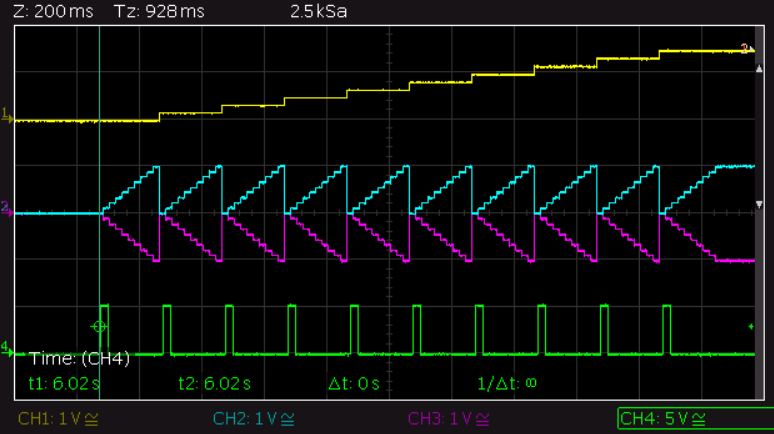

In [ ]:
qdac.print_syncs()

In [ ]:
# Set outputs back to zero
# First remove sync output so that we do not trigger an acquisition
qdac.ch02.sync(0)
qdac.ch01.v.set(0)
qdac.ch02.v.set(0)
qdac.ch03.v.set(0)

## The "mode" parameter: controlling voltage and current ranges: 
The "mode" parameter is controlling the output voltage range (by an attenuator) and the current sensor range. Only certain combinations of the two are allowed, which is why they are conrolled by a single parameter. The mode parameter is allowed values are:

Mode.vhigh_ihigh : high voltage output range / high current sensing range

Mode.vhigh_ilow  : high voltage output range / low current sensing range

Mode.vlow_ilow   : low voltage output range / low current sensing range

In [ ]:
# The "QDac.Mode" enum class is used for setting and reading the mode. 

# This will set the voltage output range to low, and the current sensor range to low
qdac.ch01.mode(Mode.vlow_ilow)
print(qdac.ch01.mode.cache().get_label())

# This will return ch01 to the default mode: high voltage range, high current sensing range
qdac.ch01.mode(Mode.vhigh_ihigh)
print(qdac.ch01.mode.cache().get_label())

### When "mode" change results in change of voltage range

When changing "mode" so that the voltage range is changed the attenuator is switched immidiately. The driver will re-adjust the output voltage in order to keep it constant, but a spike will always occur if the voltage is non-zero. If the set voltage is outside the range of the low range and the transition is from high to low range, the output will be clipped. 

To avoid spikes, the driver by default **does not allow changing the voltage range (mode)** when the output is non-zero. To over-ride this protection, set qdac.mode_force(True).

In [ ]:
# Here is a small example showing demonstrating the behavior - if posible hook up an oscilloscope on ch01
#
qdac.ch01.slope('Inf')                # Make sure that we are not fooled by a slow changing ch01   
qdac.ch01.mode(Mode.vhigh_ihigh)      # Attenuation OFF (the default), high voltage range
qdac.ch01.v(1.5)                      # Set the voltage to outside the low voltage range (but inside present range)

In [ ]:
qdac.mode_force(True)            # Enable changing voltage range eventhough the output is non-zero
qdac.ch01.mode(Mode.vlow_ilow)   # Attenuation ON, low voltage range - signal is clipped, and a dip occurred
print(qdac.ch01.v())            # Returns approximately 1.1V as the output is clipped to the low range limit

In [ ]:
qdac.ch01.mode(Mode.vhigh_ihigh)      # Attenuation off, high voltage range
print(qdac.ch01.v())                  # Returns approximately 1.1V, unchanged - but a spike occured

In [ ]:
# Return to protected mode
qdac.mode_force(False)

In [ ]:
# Now provoke an error
print(qdac.ch01.v())
print(qdac.ch01.mode.cache().get_label())     # Pretty printing the mode parameter
try:
    qdac.ch01.mode(Mode.vlow_ilow)
except ValueError as ve:
    print("ERROR: ", ve)

## Overview of channels

The driver provides a method for pretty-printing the state of all channels

The pretty-print method may or may not **update** the values for the currents, depending on the value of the `update_currents` flag. Each current reading takes some 200-500 ms, so updating all current values takes about 14-24 seconds depending on the number of channels.

In [ ]:
qdac.print_overview(update_currents=False)

## Temperature sensors
Physically, the QDac consists of either three or six boards each hosting eight channels. For diagnostics purposes temperature sensors are placed at three locations on each board,. Read-only parameters for these sensors are provided, named tempX_Y where X is the board number (0-2, or 0-5) and Y the sensor number (0-2).

In [ ]:
print(qdac.temp0_0.get(), qdac.temp0_0.unit)
print(qdac.temp2_1.get(), qdac.temp0_0.unit)

## Resetting the driver and the QDAC
To get to a well defined state, the QDAC should be powered off and then on before starting this driver.

Alternatively the reset command can be executed. The reset command can also be used to recover an off/on situation of the QDAC without having to restart the driver.

In [ ]:
qdac.reset(update_currents=False)
# Then print the overview gain
qdac.print_overview(update_currents=False)

In [ ]:
# Shut down the VISA connection
qdac.close()